## Catchment Hydrology, MSc course, VU Amsterdam
### Lecture 1: Introduction and water balance
#### Wouter R. Berghuijs (w.r.berghuijs@vu.nl) 

## Delineate a catchment

This script allows you to delineate catchments. The delineation is based on the Python package Pysheds (https://github.com/mdbartos/pysheds). 

Right now this notebook loads a digital elevation map (DEM) called 'ASTGTMV003_N49E010_dem.tif'. A Digital Elevation Model (DEM) is a representation of the bare ground (bare earth) topographic surface of the Earth excluding trees, buildings,  and any other surface objects.

The provided DEM covers of a region in the South Africa in which a main river is the Shingwedzi (see picture below). I recommend that you run the entire notebook first based on this DEM, to check if the code works. If the notebook runs properly, you can use another DEM to delineate a catchment for your own region of interest.

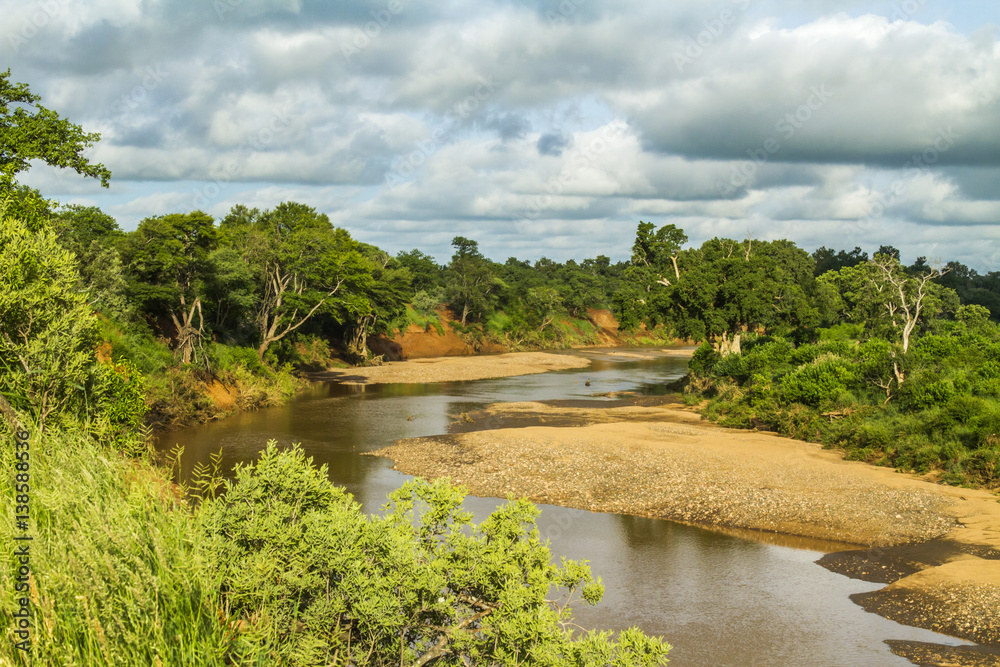


### Start of the script.
As a first step the script reads in the elevation data and associated longitudes and latitudes. This is the basis for all the analysis that follows.

In [57]:
# Read elevation raster
# ----------------------------
from pysheds.grid import Grid

grid = Grid.from_raster('ASTGTMV003_S24E030_dem.tif') 
dem = grid.read_raster('ASTGTMV003_S24E030_dem.tif')

/Users/wbs211/CATCHMENT_HYDROLOGY/Lecture_01_Introduction/Lecture_1_pysheds/pysheds/io.py:142: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/wbs211/CATCHMENT_HYDROLOGY/Lecture_01_Introduction/Lecture_1_pysheds/pysheds/io.py:142: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


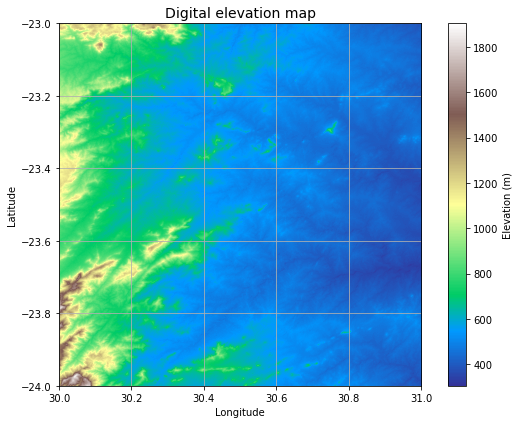

In [58]:
# Import packages
import numpy as np
import matplotlib
#import mpld3
#mpld3.enable_notebook()
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Make a plot of the elevations of the region
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

## Treat the DEM 
If we do not treat the DEM, some problems can occur in low elevations areas, surrounded by only higher elevations.

**fill_pits & fill_depressions** identifies all pits, depressions, and flats in the DEM and raises their elevation to the level of the lowest pour point around their edge. Pits, also referred to as depressions or sinks, are low elevation areas in digital elevation models (DEMs) that are completely surrounded by higher terrain. They are generally taken to be artifacts that interfere with the routing of flow across DEMs, so are removed by raising their elevationt, or filling them, to the point where they drain off the edge of the domain. The pour point is the lowest point on the boundary of the "watershed" draining to the pit.

In [59]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

## Determine the flow direction
Based on the elevation, the script determines the direction of flow and stores this as a number
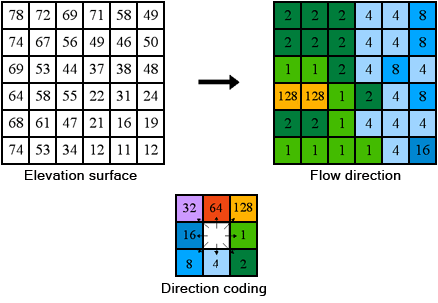

In [60]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

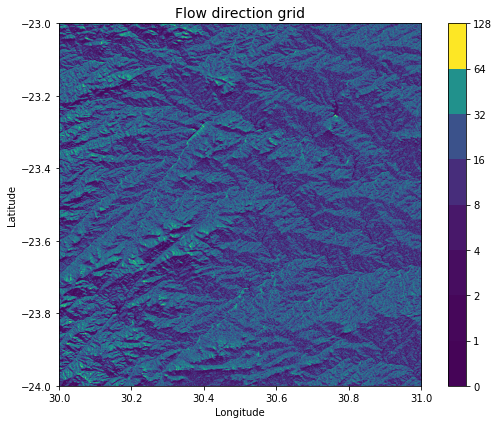

In [61]:
# Make a plot of the flow directions
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

## Flow accumulation

Based on this, the script will calculate how many upstream cells drain to each cell. Places that have many upstream cells will likely hold water, and this is where we expect our rivers to flow. 

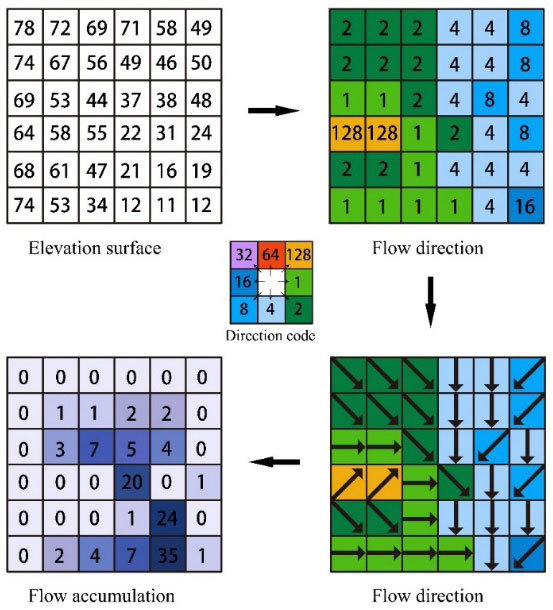

In [62]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

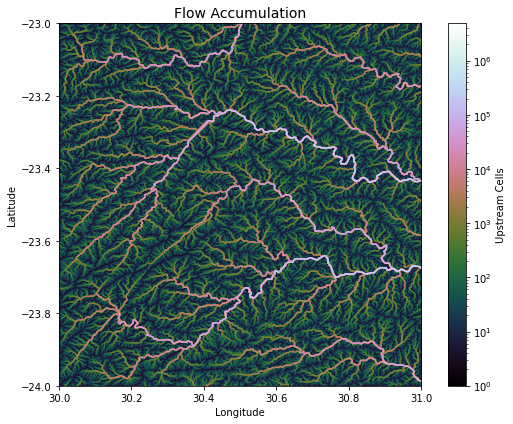

In [63]:
# Visualize flow accumulation
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

## Delineate the catchment boundaries

The code below delineates the catchment boundaries for the specified longitude and latitude (x and y below) by checking which cells drain to that particular point.

In [65]:
# Delineate a catchment
# ---------------------
# Specify the outlet location 
x, y = 30.980010, -23.169056

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

## Extract the river network

The script now estimates the flowing river network by determing where the flow accumulation exceeds 50 grid cells. Wether 50 is a realistic number depends on the spatial scale of the DEM and the local climate and landscape conditions. Therefore consider this a estimate that needs to be verified with additional data.

In [66]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

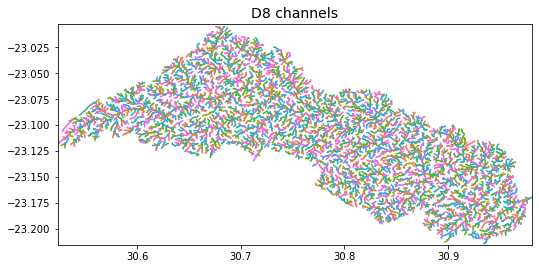

In [67]:
# Visualize the river network

sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

## Calculate distance to outlet from each cell

In [68]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

Text(0.5, 1.0, 'Flow Distance')

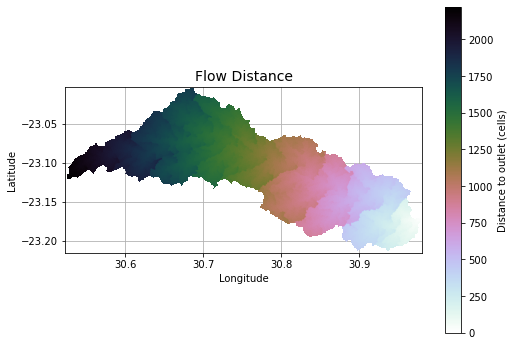

In [69]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)

# Exercise: delineate your own catchment 

1. There are various ways how you can download DEM data. I used: https://search.earthdata.nasa.gov/search. You may have to set up an account on this website to download the data.
1. On this website search for "ASTER Global Digital Elevation Model V003"
2. Zoom into the region of your interest.
3. Draw a Polygon on the region and the download options appear. 
4. Select the raster of your interest and download it
5. Store the DEM (.tif file) in the same directory as this notebook.
6. At the start of the code, change this filename in "grid = Grid.from_raster('ASTGTMV003_S24E030_dem.tif')" to the new filename (and do the same one line below)
7. Specify the coordinates of your outlet: at # Specify the outlet location x, y = 30.980010, -23.169056. You can check the coordinates of your location using, for example, Google Maps/Earth. (For example, I used "ASTGTMV003_S24E030_dem.tif" and the coordinates x, y = 30.980010, -23.169056 to derive part of the Shingwedzi River in South Africa)
8. Rerun the entire notebook from the start.